<a href="https://colab.research.google.com/github/elijahmoon-hub/Elijah-s-repository/blob/main/ElijahM_Unit5ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Unit 5 Exercises: Leverage + Practice with GLMs

In these exercises, we'll focus on:
- how to recognize high leverage values, and what to do about them.
- how to decide when a generalized linear model is better than than an all normal, straight line model

We'll start  by looking at the full NBA data set from class, and interogate why I removed so many observations from that data set.

We'll finish with another classic data set, some deemographic data from the Kalahari !Kung San people collected by Nancy Howell in Botswana between August 1967 and May 1969.

##Leverage

Let's take a look at the full basketball data set.

In [3]:
#load the data into a pandas dataframe, and print it
url_basketball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
basketball = pd.read_csv(url_basketball,dtype={'Pos':'category'})

Before, we put a minutes restriction on what players we looked at, and removed anyone who never missed a free throw.

I've commented out that code, for reference, below. We're going to attempt to run the same analysis without removing any data

In [4]:
#only look at players who played more than 400 minutes
#basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
#basketball = basketball.query('`FT%` != 1.0')

In [5]:
basketball

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


**Task1**:

Make a scatter plot with FT% of each player on the horizontal axis and FG% on the vertical axis.

What patterns do you notice? Why do you think they are there?

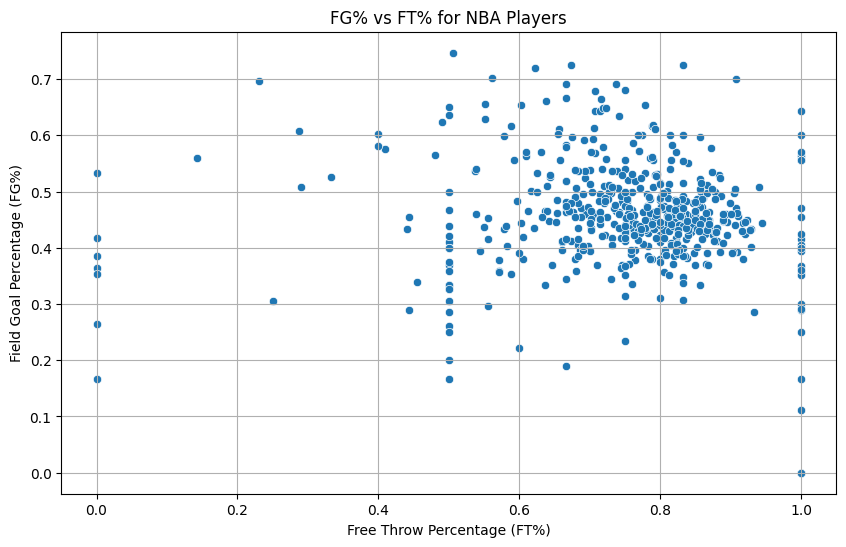

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=basketball, x='FT%', y='FG%')
plt.title('FG% vs FT% for NBA Players')
plt.xlabel('Free Throw Percentage (FT%)')
plt.ylabel('Field Goal Percentage (FG%)')
plt.grid(True)
plt.show()

**Task2**:

Make a scatter plot with FT% on the horizontal axis and FG% on the vertical axis. Do this for each each Position in the data set.

Pay special attention to the plots for C and PF.

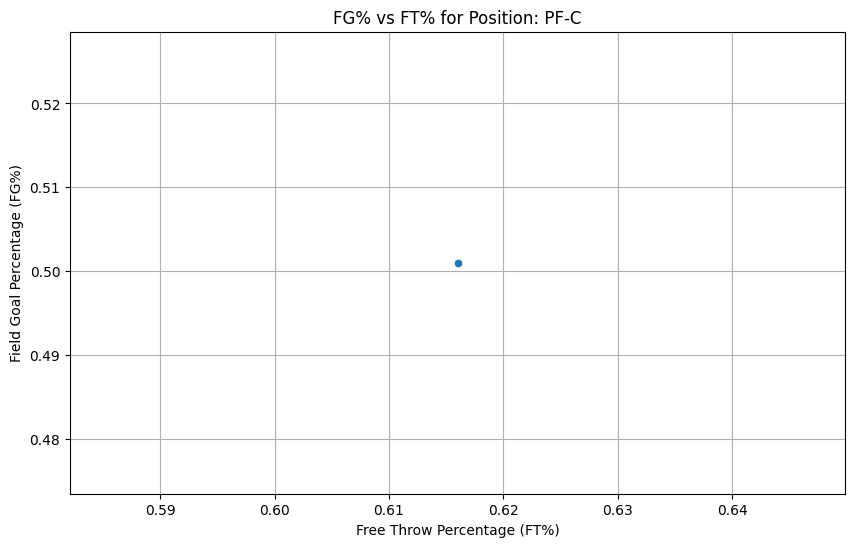

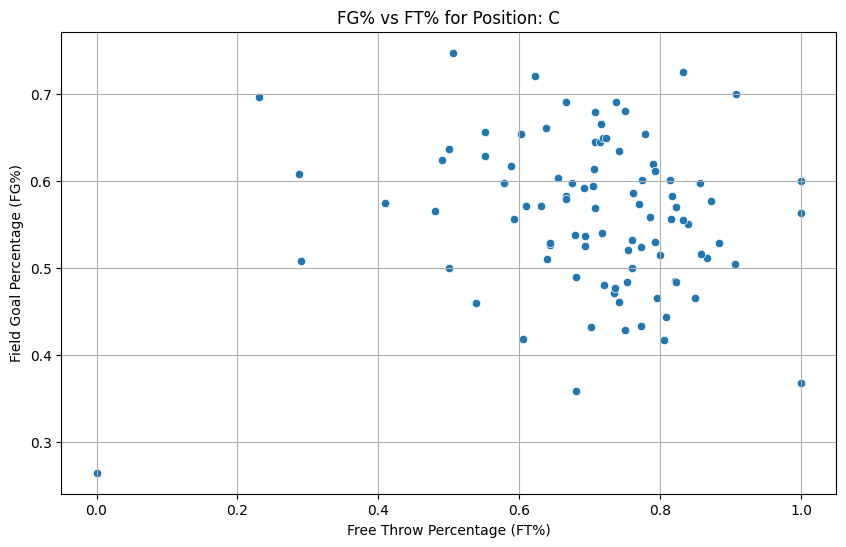

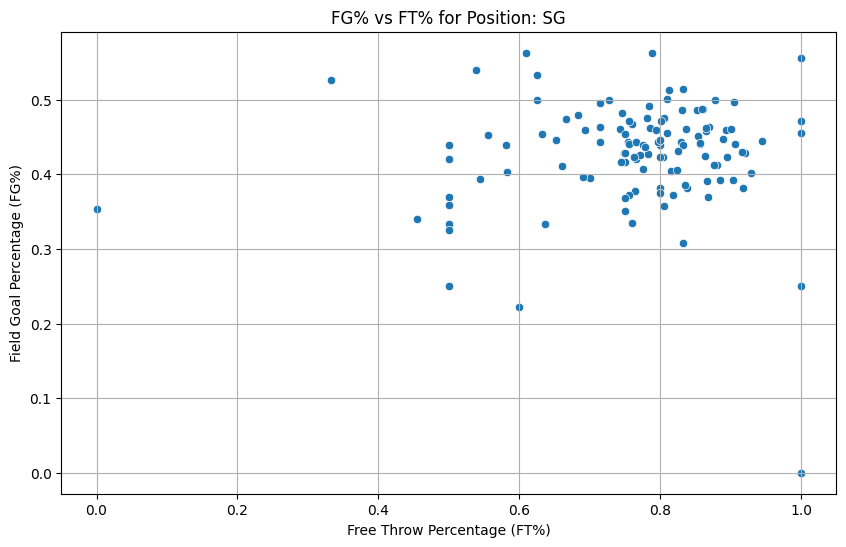

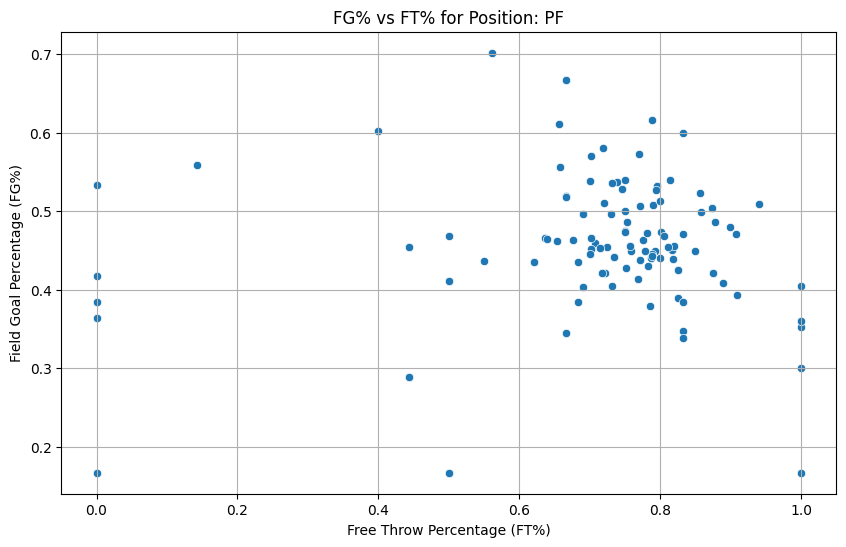

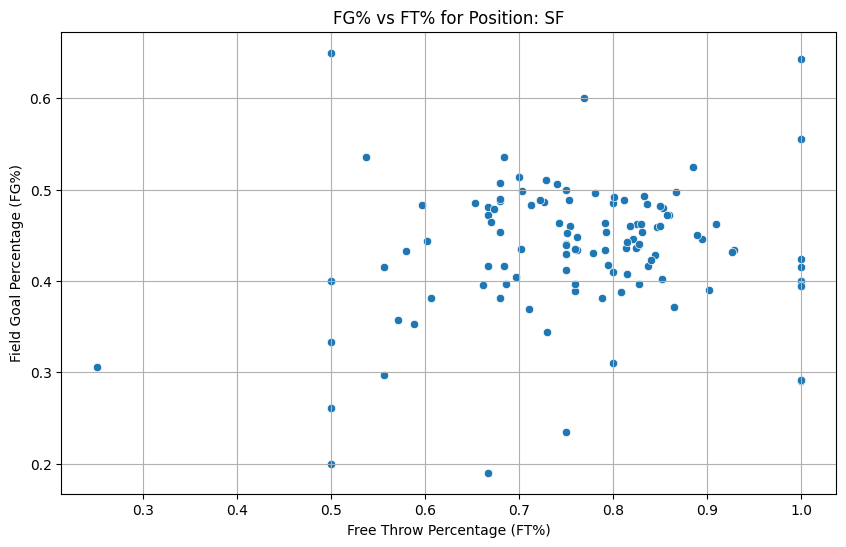

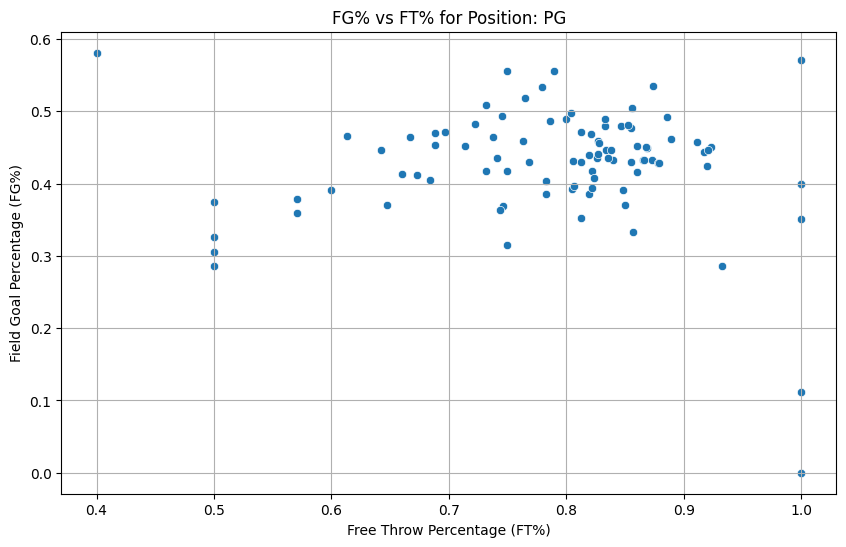

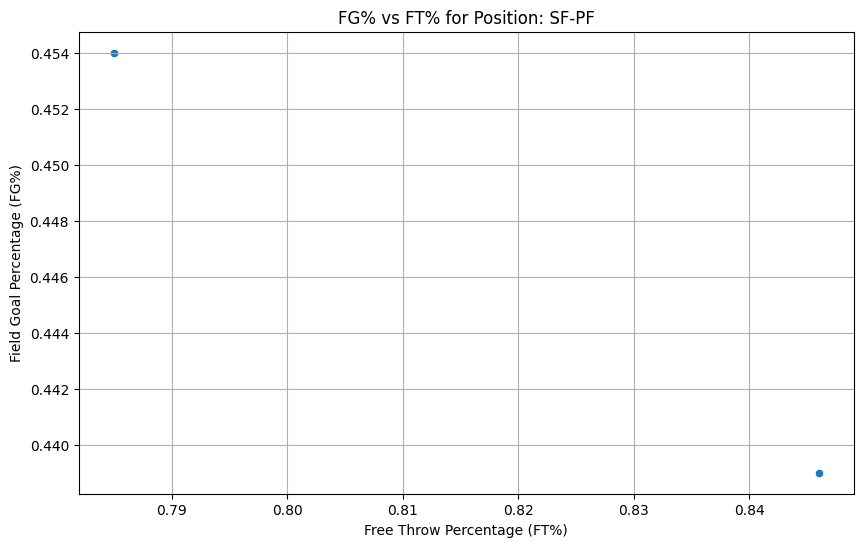

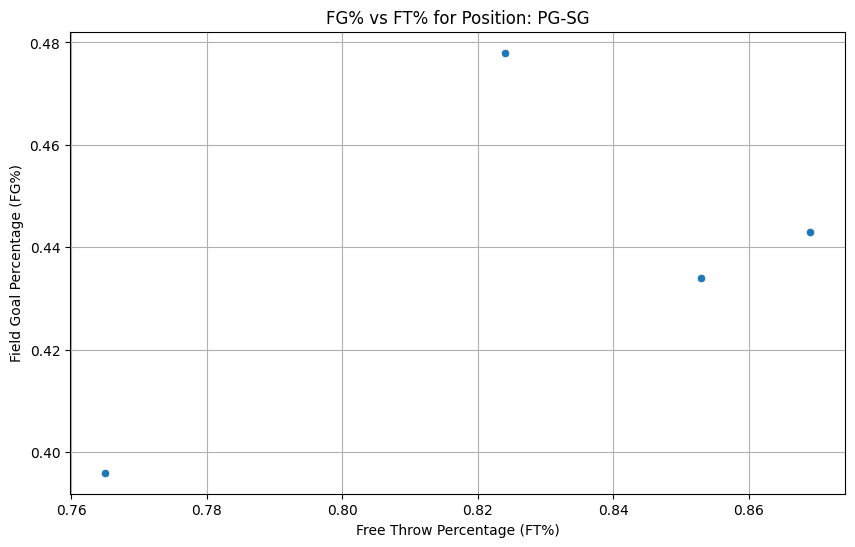

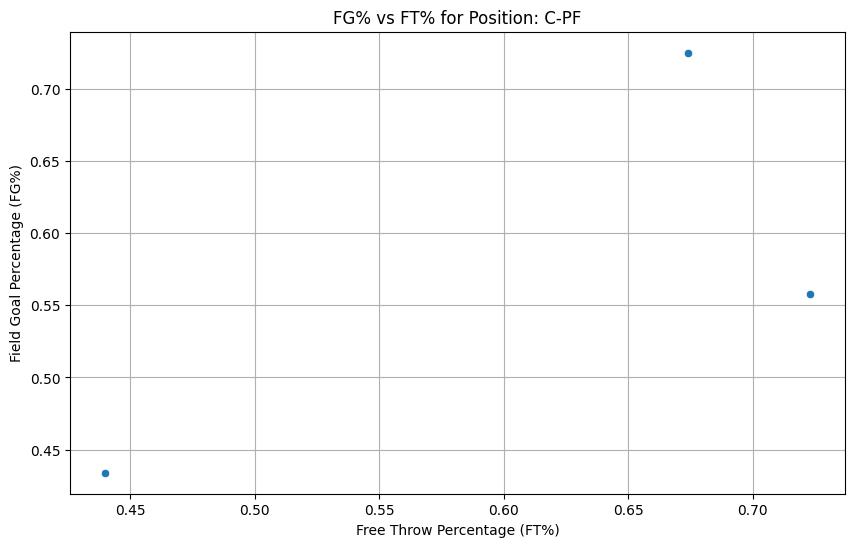

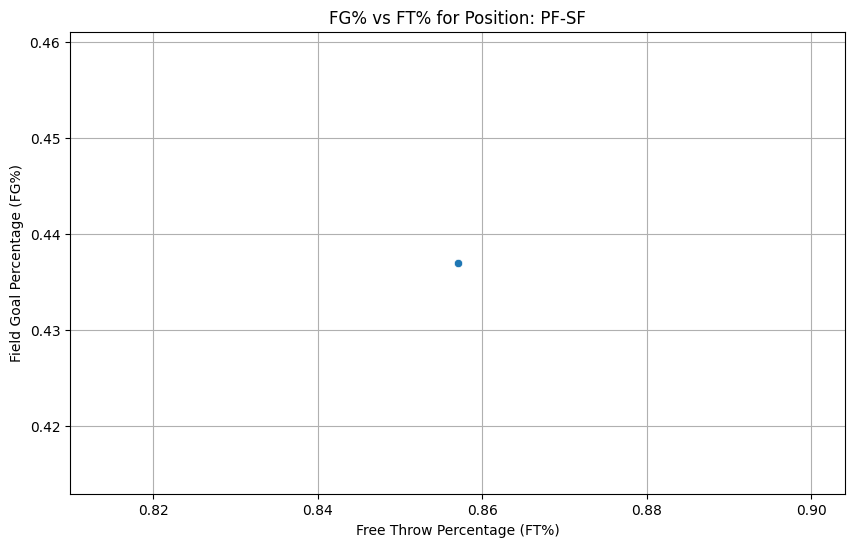

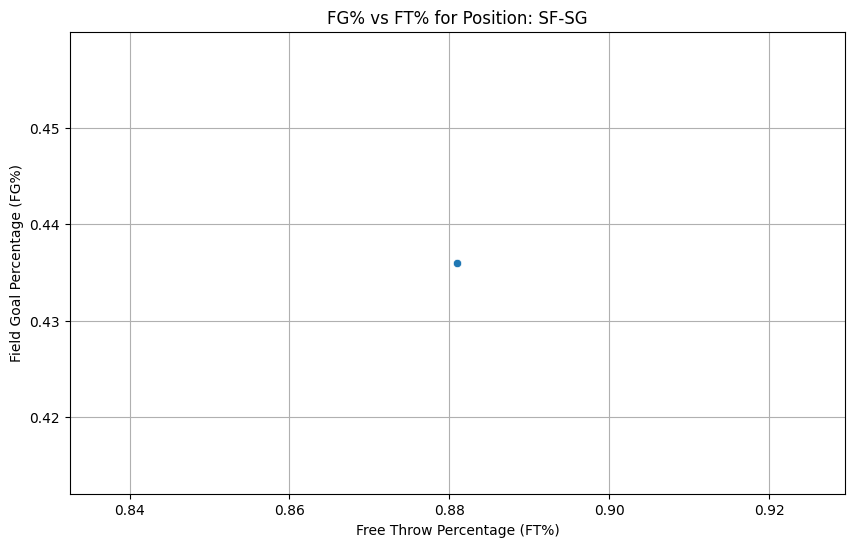

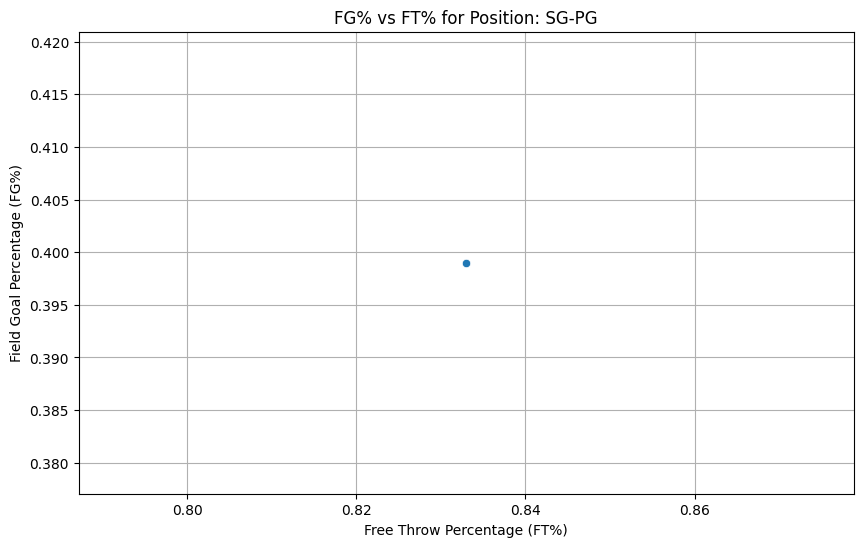

In [9]:
unique_positions = basketball['Pos'].unique()

for pos in unique_positions:
    plt.figure(figsize=(10, 6))
    position_data = basketball[basketball['Pos'] == pos]
    sns.scatterplot(data=position_data, x='FT%', y='FG%')
    plt.title(f'FG% vs FT% for Position: {pos}')
    plt.xlabel('Free Throw Percentage (FT%)')
    plt.ylabel('Field Goal Percentage (FG%)')
    plt.grid(True)
    plt.show()

**Task3**:

Originally, I was going to get you to create and run an individual linear regression model for each of the positions.

But I couldn't even get model to run.

Explain why a linear regression model won't run on the full dataset. HInt: look at the graphs you made above, and compare and contrast them to the ones from class.

Or: if you do what I could not and get a linear regression model to run on the full data set, I'll give you full credit and a high five.

The linear regression models won't run because there is no clear identified trend in some of the scatter plot models.The models from class reveal that if you can draw a horizontal line in the orange area, then theres' no relationship between FT% and FG% for that position. There's not enough data for the model to accurately reprsent a relationship/trend.

## From Linear Model to Generalized Linear Model

You'll now fit a linear regression on the height and weight for people or the Kalahari !Kung San people. Height will be the predictor and weight will be the predicted.

Here's the raw data.

In [7]:
#downloads the data from my github
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [8]:
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


**Task4**:

Make a scatter plot of height versus weight for the howell data set.

**Task5**:

Create and run a stright line linear regression model on the howell data set with height predicting weight. Visualize your model and its posterior.

**Task6**:

Run a posterior predictive check for model_howell, plot the posterior predictive distribution, and comment on the fit of the model you made in Task5.

**Task7**:

Create and visualize the posterior of a generalized linear model that improves the on the fit of the model you made in Task5.

In [10]:
howell['height_squared'] = howell['height']**2
print("Added 'height_squared' column to howell DataFrame.")

Added 'height_squared' column to howell DataFrame.


In [ ]:
with pm.Model() as model_glm:
    # Priors for the parameters
    alpha = pm.Normal('alpha', mu=howell['weight'].mean(), sigma=10)
    beta1 = pm.Normal('beta1', mu=0, sigma=10) # For height
    beta2 = pm.Normal('beta2', mu=0, sigma=10) # For height_squared
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Expected mean of the weight
    mu = alpha + beta1 * howell['height'] + beta2 * howell['height_squared']

    # Likelihood for the observed weight
    weight_likelihood = pm.Normal('weight', mu=mu, sigma=sigma, observed=howell['weight'])

    # Fit the model
    idata_glm = pm.sample(draws=2000, tune=2000, cores=2, return_inferencedata=True)

print("Generalized Linear Model defined and fitted successfully.")

Posterior distributions of GLM parameters visualized.


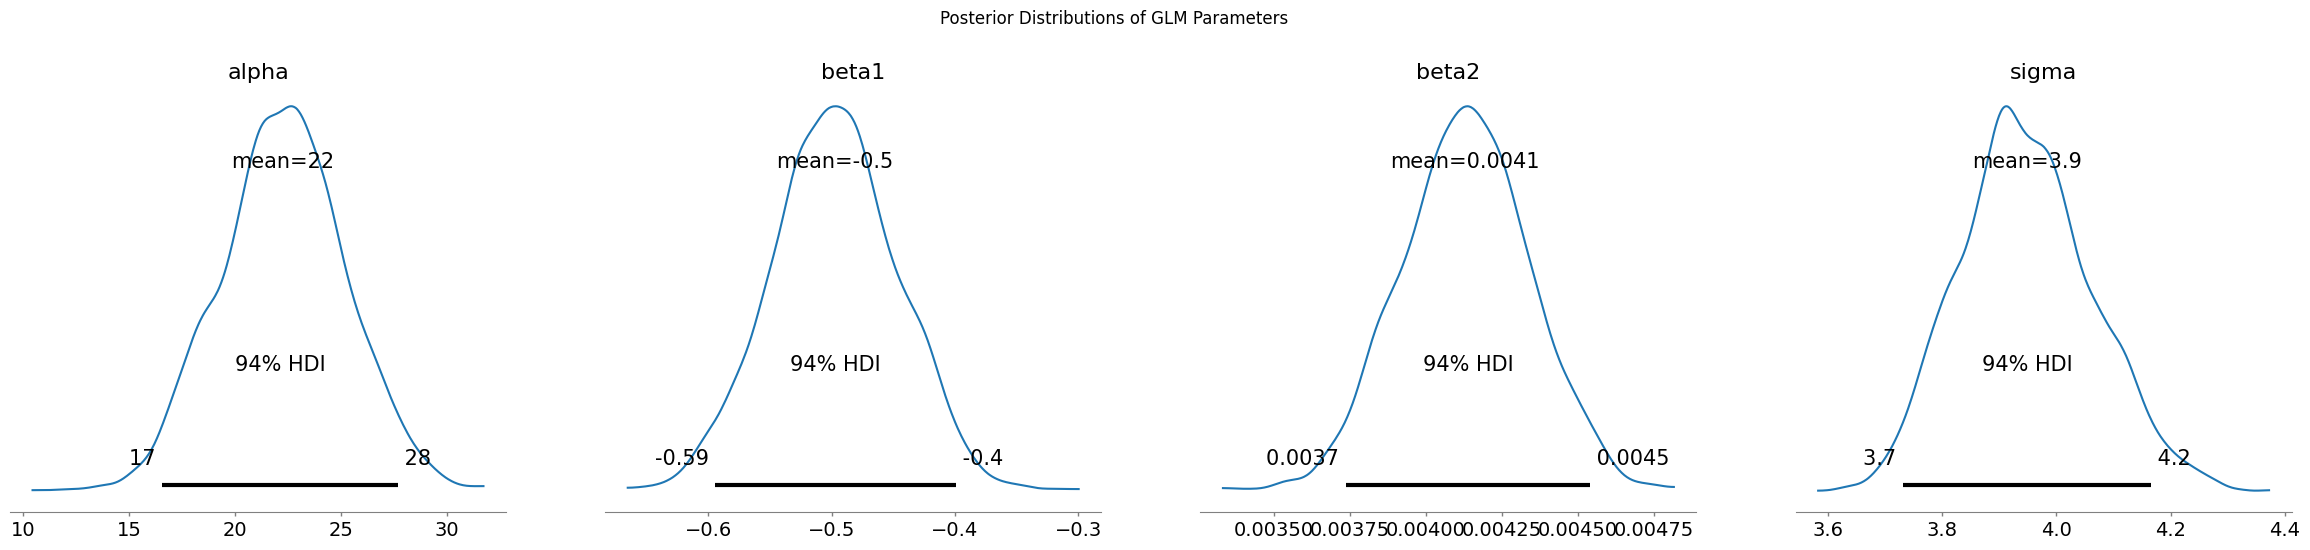

In [12]:
az.plot_posterior(idata_glm, var_names=['alpha', 'beta1', 'beta2', 'sigma']);
plt.suptitle('Posterior Distributions of GLM Parameters', y=1.02);
print("Posterior distributions of GLM parameters visualized.")

**Task8**:

Run a posterior predictive check, and visualize the posterior predictive distribution, for the model you made in Task7.

Comment on the fit.

## Final Task

### Subtask:
Review the generated plots and identify any noticeable patterns or differences in FG% and FT% relationships across various player positions.
